# Mini-projet n°1 - Qui a peint ce tableau ?

In [62]:
# Utils
import os
import shutil
import time

# Maths - Stats
import math
from sklearn.utils import shuffle
from sklearn.utils import resample
import numpy as np
import pandas as pd
import random as rd
from collections import Counter

# Data visualization
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16

In [63]:
[k.device_type for k in tf.config.list_physical_devices()]

['CPU', 'GPU']

## 1. Analyse exploratoire

### 1.1 Création du jeu de données

Le choix des images HQ est motivé par la richesse des détails qu'elles conservent, essentiels pour différencier les artistes. Ces images préservent les traits subtils de pinceau, les textures, et les nuances exactes des couleurs, qui sont souvent perdus dans les images compressées. La tâche complexe d’identifier un artiste nécessite une résolution élevée pour analyser ces caractéristiques distinctives.

De plus, les modèles pré-entraînés (comme ResNet ou VGG) sont conçus pour traiter des images de qualité élevée, maximisant ainsi leurs performances. Bien que cela exige davantage de ressources, cette approche est indispensable pour exploiter pleinement les informations visuelles et compenser la taille limitée du dataset.

In [67]:
# Chemin des images haute définition
path = "images_hq"

# Suppression et création du dossier "data"
if os.path.exists("data"):
    shutil.rmtree("data")
os.mkdir("data")

# Initialisation des listes pour stocker les données
images = []
peintres = []

# Parcours des sous-dossiers (un par peintre)
for dossier_auteur in sorted(os.listdir(path)):  # Trie les sous-dossiers
    path_auteur = os.path.join(path, dossier_auteur)
    if os.path.isdir(path_auteur):  # Vérifie que c'est un dossier
        for image in sorted(os.listdir(path_auteur)):  # Trie les fichiers
            src = os.path.join(path_auteur, image)  # Chemin source
            dst = os.path.join("data", image)      # Chemin destination
            
            # Copie l'image dans le dossier "data"
            shutil.copyfile(src, dst)
            
            # Ajoute les informations dans les listes
            images.append(image)
            peintres.append(dossier_auteur)  # Le nom du dossier correspond au peintre

In [68]:
data = pd.DataFrame({
    'images': images,
    'peintre': peintres
})

In [69]:
data.shape

(8447, 2)

In [70]:
data.head()

images         peintre
0    Albrecht_Dürer_1.jpg  Albrecht_Dürer
1   Albrecht_Dürer_10.jpg  Albrecht_Dürer
2  Albrecht_Dürer_100.jpg  Albrecht_Dürer
3  Albrecht_Dürer_101.jpg  Albrecht_Dürer
4  Albrecht_Dürer_102.jpg  Albrecht_Dürer

In [71]:
sorted_data = data.iloc[:, 1].value_counts(ascending=False)
sorted_data

peintre
Vincent_van_Gogh             878
Edgar_Degas                  702
Pablo_Picasso                439
Pierre-Auguste_Renoir        336
Albrecht_Dürer               328
Paul_Gauguin                 311
Francisco_Goya               291
Rembrandt                    262
Alfred_Sisley                259
Titian                       255
Marc_Chagall                 239
Rene_Magritte                194
Amedeo_Modigliani            193
Paul_Klee                    188
Henri_Matisse                186
Andy_Warhol                  181
Mikhail_Vrubel               171
Sandro_Botticelli            164
Leonardo_da_Vinci            143
Peter_Paul_Rubens            141
Salvador_Dali                139
Hieronymus_Bosch             137
Pieter_Bruegel               134
Diego_Velazquez              128
Kazimir_Malevich             126
Frida_Kahlo                  120
Giotto_di_Bondone            119
Gustav_Klimt                 117
Raphael                      109
Joan_Miro                    102
An

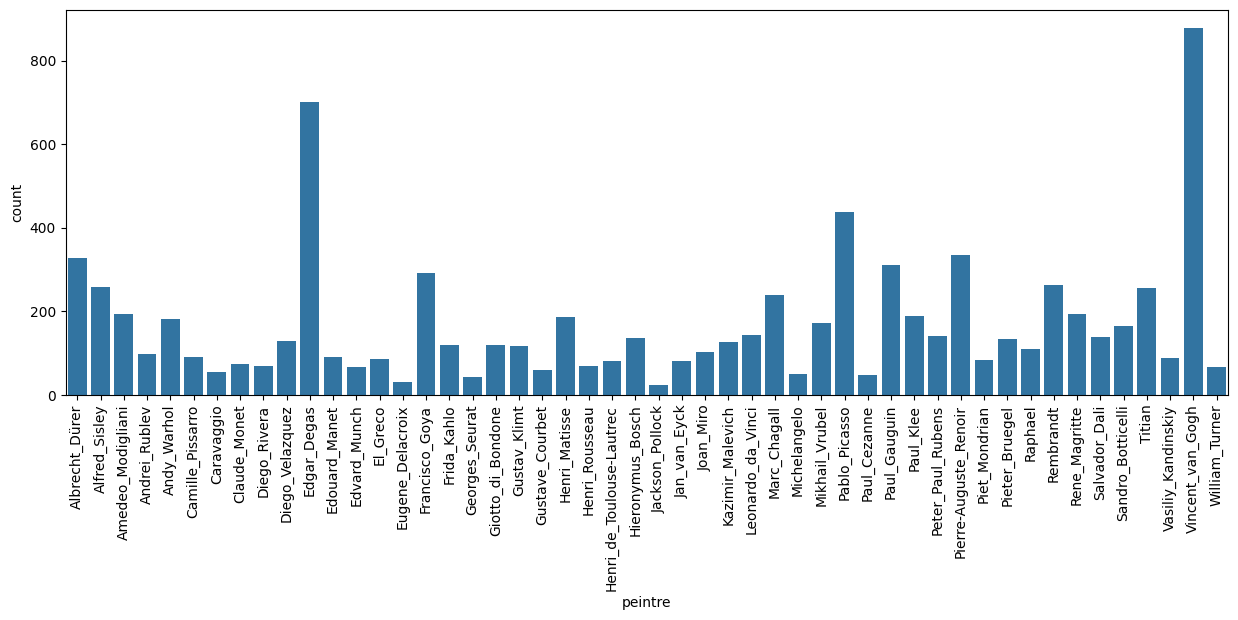

In [72]:
plt.figure(figsize=(15,5))
sns.countplot(x=data["peintre"])
plt.xticks(rotation=90)
plt.show()

Le jeu de données est déséquilibré entre les classes, chaque artiste à un nombre d'oeuvre totalement différent allant de 877 pour Van Gogh à 24 pour Pollock. Ce déséquilibre peut biaiser l'apprentissage du modèle, qui pourrait privilégier les classes majoritaires au détriment des minoritaires.

Le rééquilibrage permet de garantir que le modèle ne développe pas de préférence pour certains artistes, mais qu'il apprenne à reconnaître chaque classe de manière équitable. Cela peut être réalisé en sous-échantillonnant les classes majoritaires. Cette démarche améliore la capacité de généralisation du modèle et garantit des prédictions plus robustes et équitables.

In [74]:
auteur_counts = data['peintre'].value_counts()

# Fonction pour limiter le nombre d'images entre un minimum et un maximum
def reduce_images(data, min_images=150, max_images=400):
    if len(data) < min_images:
        return pd.DataFrame()  # Exclure les peintres ayant moins que le minimum
    if len(data) > max_images:
        return data.sample(n=max_images, random_state=25)  # Réduire au maximum
    return data  

groups = [reduce_images(group) for _, group in data.groupby('peintre')]
data_balanced = pd.concat(groups, ignore_index=True)

print("Distribution des classes après équilibrage :")
print(data_balanced['peintre'].value_counts())

Distribution des classes après équilibrage :
peintre
Pablo_Picasso            400
Edgar_Degas              400
Vincent_van_Gogh         400
Pierre-Auguste_Renoir    336
Albrecht_Dürer           328
Paul_Gauguin             311
Francisco_Goya           291
Rembrandt                262
Alfred_Sisley            259
Titian                   255
Marc_Chagall             239
Rene_Magritte            194
Amedeo_Modigliani        193
Paul_Klee                188
Henri_Matisse            186
Andy_Warhol              181
Mikhail_Vrubel           171
Sandro_Botticelli        164
Name: count, dtype: int64


In [75]:
data_balanced.shape

(4758, 2)

In [76]:
nclasses = len(data_balanced.peintre.unique())
print(nclasses)

18


In [77]:
data_balanced

images           peintre
0         Albrecht_Dürer_1.jpg    Albrecht_Dürer
1        Albrecht_Dürer_10.jpg    Albrecht_Dürer
2       Albrecht_Dürer_100.jpg    Albrecht_Dürer
3       Albrecht_Dürer_101.jpg    Albrecht_Dürer
4       Albrecht_Dürer_102.jpg    Albrecht_Dürer
...                        ...               ...
4753  Vincent_van_Gogh_727.jpg  Vincent_van_Gogh
4754  Vincent_van_Gogh_141.jpg  Vincent_van_Gogh
4755  Vincent_van_Gogh_511.jpg  Vincent_van_Gogh
4756  Vincent_van_Gogh_501.jpg  Vincent_van_Gogh
4757  Vincent_van_Gogh_467.jpg  Vincent_van_Gogh

[4758 rows x 2 columns]

### 1.2 Images de notre jeu de données

On affiche 6 tableaux au hasard parmis toute la banque de données

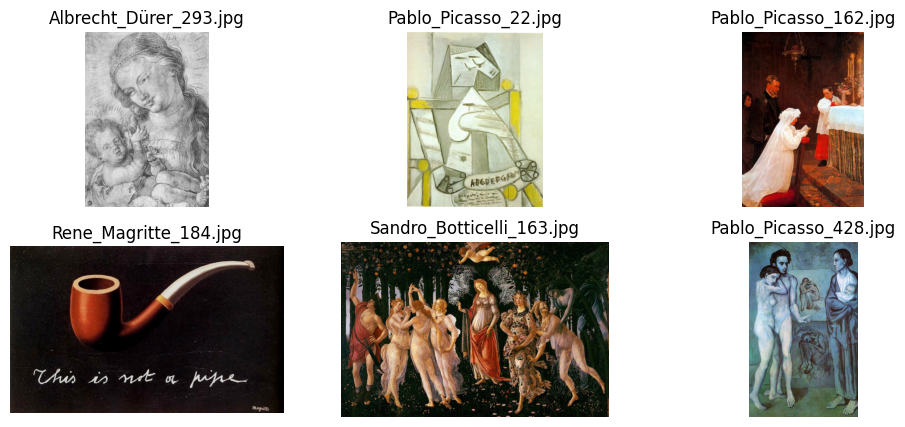

In [80]:
fig,axe=plt.subplots(2,3,figsize=(12,5))

for i in range(2):
    for j in range(3):
        nom_image = rd.choice(data_balanced['images'])
        img = load_img("data/" + nom_image)
        
        axe[i, j].imshow(img)  
        axe[i, j].set_title(nom_image)
        axe[i, j].axis('off')

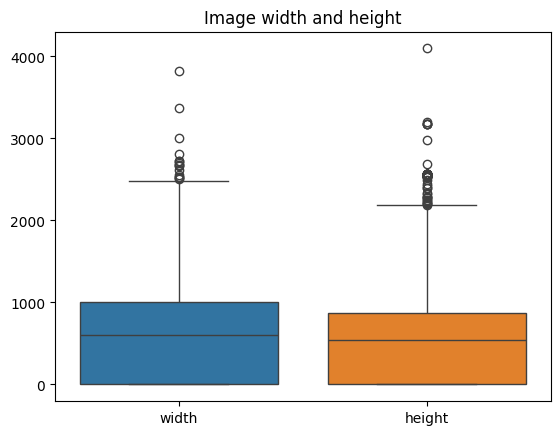

In [81]:
img_size = np.zeros((data.shape[0],2))
for i, nom_image in enumerate(data_balanced['images']) :
    img = img_to_array(load_img("data/" + nom_image))
    img_size[i,:] = img.shape[:2]

# --- #

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()

Redimensionner les images est une étape essentielle pour garantir leur compatibilité avec les modèles de deep learning, qui nécessitent des dimensions d’entrée fixes (par exemple, 224x224 pour VGG16). Cela permet d’uniformiser la taille des images, évitant ainsi des erreurs lors du traitement en lot (batching).

De plus, réduire la résolution des images à une taille standard limite les besoins en mémoire et accélère l’entraînement sans compromettre significativement la qualité des informations visuelles nécessaires à la classification. Cette étape optimise l’utilisation des ressources computationnelles tout en maintenant la pertinence des caractéristiques visuelles analysées.

## 2. Préparation des images et transformations

L'encodage des peintres est nécessaire pour transformer leurs noms en une représentation numérique que le modèle de deep learning peut comprendre. Cela permet de mapper chaque peintre à une classe unique sous forme d’entiers.

Cette étape garantit que le modèle traite les artistes comme des catégories distinctes lors de l’entraînement, ce qui est essentiel pour résoudre une tâche de classification. Sans cet encodage, le modèle serait incapable de faire correspondre les sorties prédictives aux artistes ciblés.

In [85]:
label_encoder = LabelEncoder()

df = data_balanced
df['peintre'] = label_encoder.fit_transform(df['peintre'])
df['peintre'] = df['peintre'].astype('str')

df.head()

images peintre
0    Albrecht_Dürer_1.jpg       0
1   Albrecht_Dürer_10.jpg       0
2  Albrecht_Dürer_100.jpg       0
3  Albrecht_Dürer_101.jpg       0
4  Albrecht_Dürer_102.jpg       0

La séparation du dataset en plusieurs sous-ensembles est essentielle pour garantir la fiabilité et la robustesse du modèle. Voici les rôles de chaque sous-ensemble :

1. **Ensemble d'entraînement** : Utilisé pour ajuster les paramètres du modèle. Il constitue généralement la plus grande portion des données (ici 80% du total avant validation).

2. **Ensemble de validation** : Utilisé pour évaluer les performances du modèle pendant l'entraînement et ajuster les hyperparamètres. En réservant 25% de l'ensemble d'entraînement (soit 20% du total), on évite que les performances du modèle soient surévaluées.

3. **Ensemble de test** : Ce sous-ensemble final (20% du total) permet d'évaluer les performances réelles du modèle sur des données qu'il n'a jamais vues, assurant une estimation honnête de sa capacité de généralisation.

Cette méthodologie garantit que le modèle n'est pas surentraîné et qu'il performe bien sur des données inconnues.

In [87]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=25)
train_df, validation_df = train_test_split(train_df, test_size=0.25, random_state=25)  

In [88]:
batch_size = 32
img_width = 224
img_height = 224

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
     "data/",
    x_col = 'images',
    y_col = 'peintre',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
     "data/",
    x_col = 'images',
    y_col = 'peintre',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
     "data/",
    x_col = 'images',
    y_col = 'peintre',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 2854 validated image filenames belonging to 18 classes.
Found 952 validated image filenames belonging to 18 classes.
Found 952 validated image filenames belonging to 18 classes.


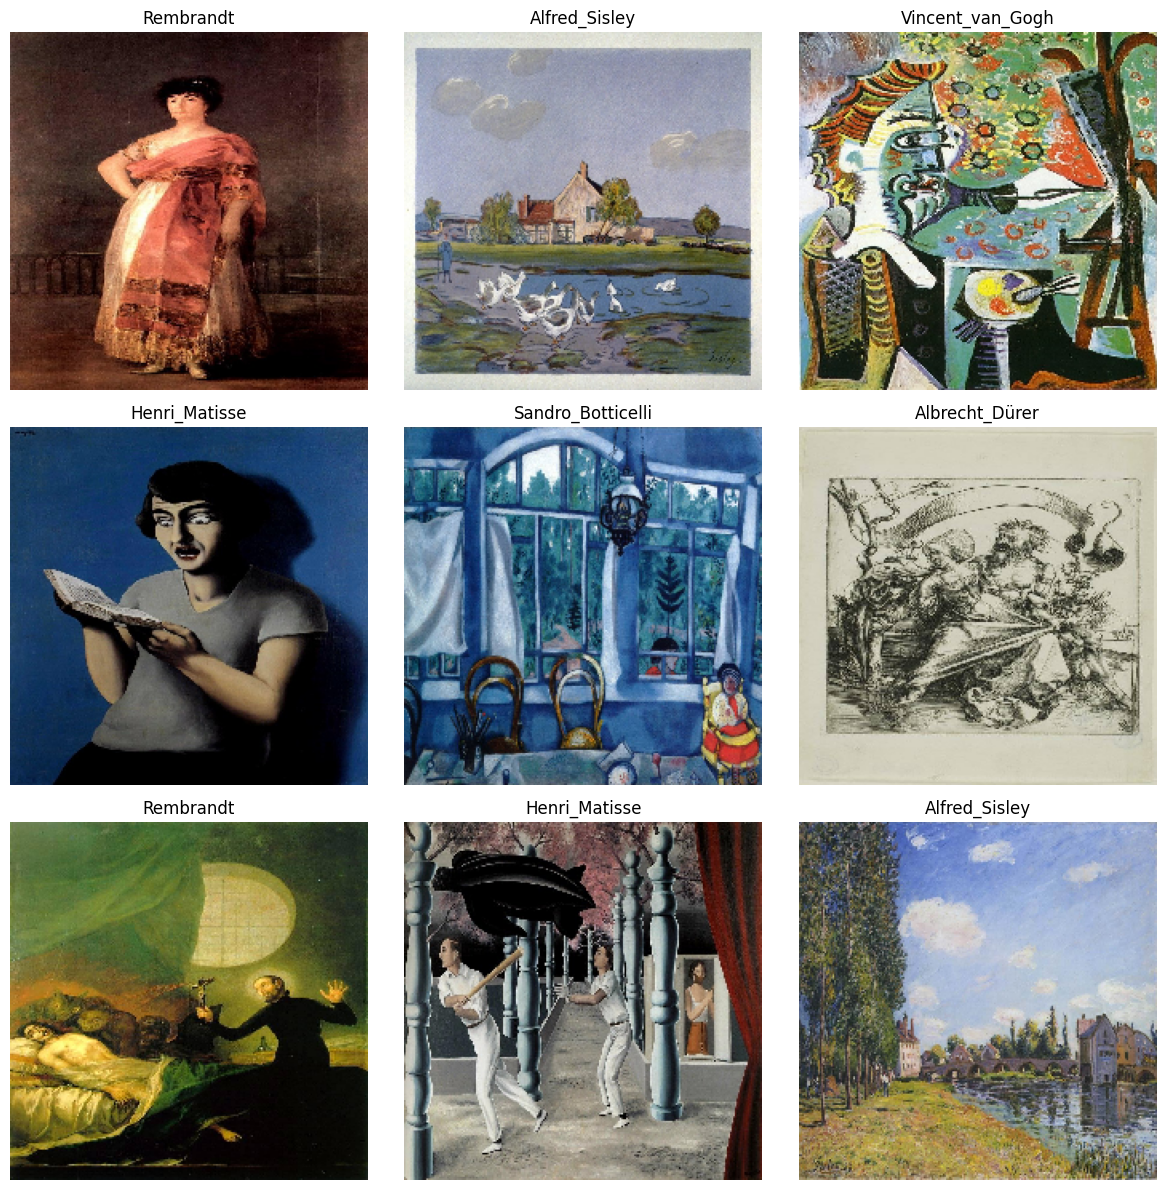

In [89]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in train_generator:
        img = x_batch[0]
        label_index = y_batch[0].argmax()
        plt.title(label_encoder.inverse_transform([label_index])[0])
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break

plt.tight_layout()
plt.show()

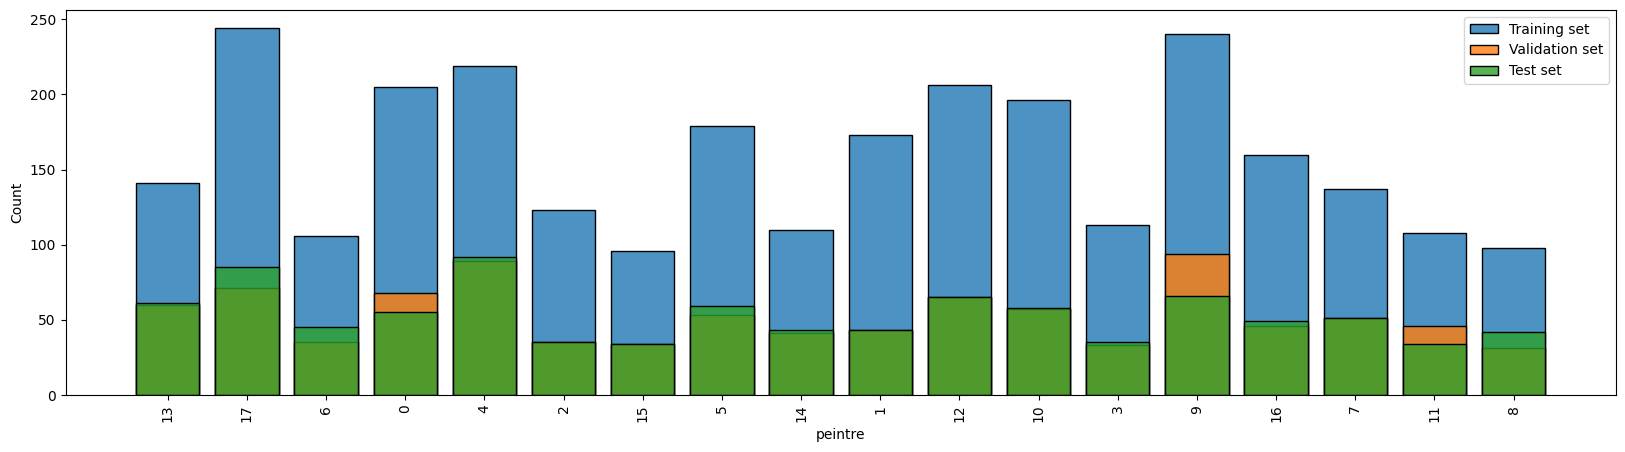

In [90]:
plt.figure(figsize=(20,5))

sns.histplot(train_df.iloc[:,1],label="Training set",discrete=True, alpha=.8, shrink=.8)
sns.histplot(validation_df.iloc[:,1],label="Validation set",discrete=True, alpha=.8, shrink=.8)
sns.histplot(test_df.iloc[:,1],label="Test set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()
plt.show()

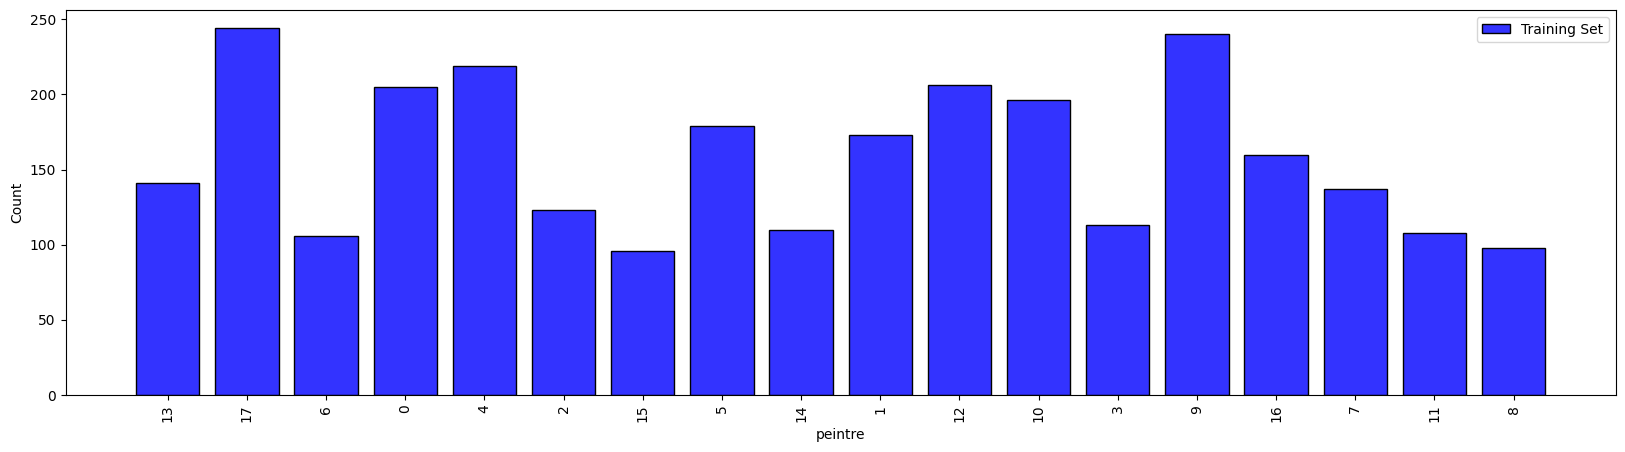

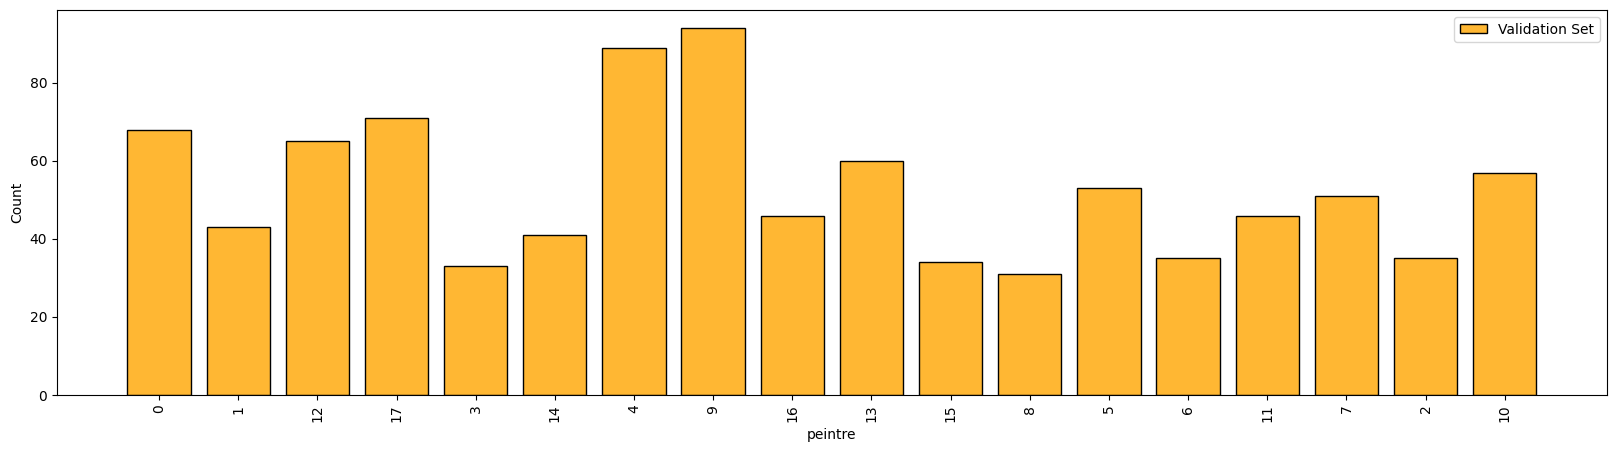

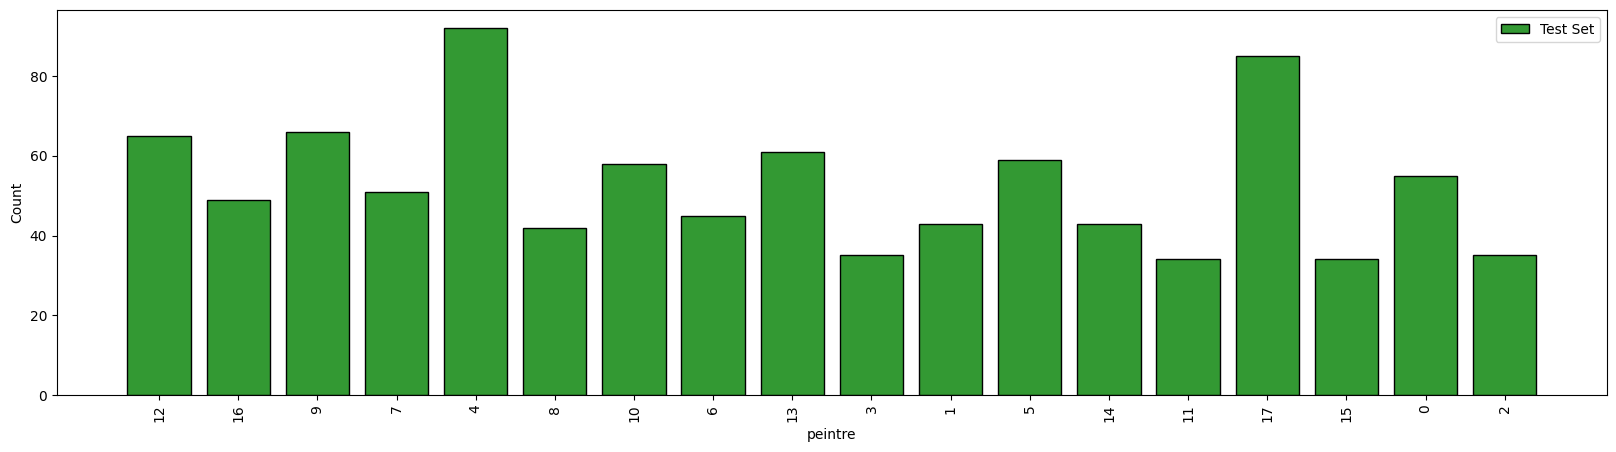

In [91]:
plt.figure(figsize=(20, 5))
sns.histplot(train_df.iloc[:, 1], label="Training Set", color="blue", discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()

plt.figure(figsize=(20, 5))
sns.histplot(validation_df.iloc[:, 1], label="Validation Set", color="orange", discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()

plt.figure(figsize=(20, 5))
sns.histplot(test_df.iloc[:, 1], label="Test Set", color="green", discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()

plt.show()

Le graphique montre la distribution des données pour chaque peintre entre les ensembles d'entraînement, de validation, et de test :
- La répartition semble bien équilibrée pour chaque peintre, avec une proportion similaire entre les trois ensembles. Cela garantit que le modèle pourra généraliser sur les données de test sans être influencé par un déséquilibre.
- Cette répartition équilibrée par classe est importante pour que le modèle puisse apprendre de manière équitable sur chaque artiste, tout en assurant une évaluation représentative de ses performances sur des données inconnues.

## 3. Première approche : Réseau pré-entrainé

L’utilisation de **VGG16 pré-entraîné** repose sur les avantages de l’apprentissage transféré, qui permet de réutiliser les connaissances acquises sur de larges datasets (comme ImageNet) pour résoudre des tâches spécifiques.

#### Pourquoi VGG16 ?
- **Architecture robuste** : VGG16 est un réseau bien connu pour sa simplicité et son efficacité dans la classification d'images. Sa structure, composée de couches convolutives et de max-pooling, permet une extraction de caractéristiques détaillées.
- **Pré-entraînement sur ImageNet** : Le modèle a déjà appris à extraire des caractéristiques générales pertinentes à partir d’un grand nombre d’images. Ces connaissances peuvent être transférées pour identifier les styles et les caractéristiques propres aux peintres dans ce projet.
- **Réduction du temps d’entraînement** : En utilisant un modèle pré-entraîné, seules les couches supérieures (classificateur) doivent être adaptées à la tâche, ce qui diminue les besoins en ressources et accélère le processus.

Cette approche permet de combiner la puissance d’un modèle généralisé avec une spécialisation pour les peintures du dataset, tout en optimisant l’utilisation des ressources et le temps d’entraînement.

In [95]:
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
train_features = conv_base.predict(train_generator)
train_features = np.reshape(train_features,(train_features.shape[0], -1))

validation_features = conv_base.predict(validation_generator)
validation_features = np.reshape(validation_features,(validation_features.shape[0], -1))

/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 414ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 434ms/step


In [97]:
train_data = train_df.to_numpy()
y_train = np.array([int(numeric_string) for numeric_string in train_data[:,1]])

validation_data = validation_df.to_numpy()
y_validation = np.array([int(numeric_string) for numeric_string in validation_data[:,1]])

In [98]:
y_train = to_categorical(y_train, num_classes=nclasses)
y_validation = to_categorical(y_validation, num_classes=nclasses)

In [99]:
vgg_mlp = Sequential()
vgg_mlp.add(Input((train_features.shape[1],)) )
vgg_mlp.add(Dense(256, activation='relu'))
vgg_mlp.add(Dropout(0.5))
vgg_mlp.add(Dense(nclasses, activation='softmax'))

vgg_mlp.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,427,410 (24.52 MB)

 Trainable params: 6,427,410 (24.52 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
epochs = 50

vgg_mlp.compile(
    loss = 'CategoricalCrossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_mlp = time.time()
vgg_mlp_history = vgg_mlp.fit(
    train_features, y_train,
    validation_data = (validation_features, y_validation),
    epochs = epochs
)
t_learning_vgg_mlp = time.time() - t_learning_vgg_mlp

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_mlp))

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0663 - loss: 3.1209 - val_accuracy: 0.0914 - val_loss: 2.8829
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0750 - loss: 2.8880 - val_accuracy: 0.0714 - val_loss: 2.8889
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0847 - loss: 2.8821 - val_accuracy: 0.0746 - val_loss: 2.8907
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0845 - loss: 2.8676 - val_accuracy: 0.1029 - val_loss: 2.8774
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0909 - loss: 2.8612 - val_accuracy: 0.0819 - val_loss: 2.8743
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0975 - loss: 2.8462 - val_accuracy: 0.0788 - val_loss: 2.8888
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0884 - loss: 2.8451 - val_accuracy: 0.0872 - val_loss: 2.8894
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1015 - loss: 2.8323 - val_accuracy: 0.0851 - v

In [101]:
t_prediction_vgg_mlp = time.time()

score_vgg_mlp_train = vgg_mlp.evaluate(train_features, y_train)
score_vgg_mlp_validation = vgg_mlp.evaluate(validation_features, y_validation)

t_prediction_vgg_mlp = time.time() - t_prediction_vgg_mlp

print('Train accuracy:', score_vgg_mlp_train[1])
print('Validation accuracy:', score_vgg_mlp_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_mlp )

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7492 - loss: 1.1895
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0764 - loss: 3.4476
Train accuracy: 0.7389628887176514
Validation accuracy: 0.07773109525442123
Time Prediction: 1.09 seconds


In [102]:
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [103]:
plot_training_analysis(vgg_mlp_history)

#### Observations générales

1. **Graphique de précision (`accuracy`) :**
   - La précision sur les données d'entraînement augmente de manière continue, atteignant environ 35 % à la fin des 50 époques.
   - La précision sur les données de validation reste faible et fluctue autour de 10 % tout au long de l'entraînement.

2. **Graphique des pertes (`loss`) :**
   - La perte d'entraînement diminue de manière significative, indiquant que le modèle s'ajuste aux données d'entraînement.
   - La perte de validation augmente légèrement après les premières époques, indiquant que le modèle ne parvient pas à généraliser.

#### Interprétation

Ces résultats montrent que le modèle est **sévèrement surajusté (`overfitting`)**. 

1. **Surajustement évident** :
   - L'écart entre la précision d'entraînement et celle de validation est très large. Le modèle apprend bien les données d'entraînement mais ne parvient pas à capturer des informations utiles pour les données de validation.

2. **Manque de généralisation** :
   - La stagnation ou légère augmentation de la perte de validation et l'absence d'amélioration dans la précision de validation indiquent un manque de généralisation. 

## 4. Deuxième approche : Apprentissage par transfert avec augmentation des données

L'apprentissage par transfert est une méthode puissante qui combine un modèle pré-entraîné avec des techniques d'augmentation des données pour améliorer les performances sur des datasets spécifiques.

#### Pourquoi l'apprentissage par transfert ?
- **Réutilisation d’un modèle pré-entraîné** : En partant des poids appris sur ImageNet, le modèle peut identifier des caractéristiques visuelles complexes et les adapter à la classification des peintres.
- **Optimisation des ressources** : L'apprentissage par transfert réduit le temps et les besoins en données nécessaires pour entraîner un modèle à partir de zéro.

#### Pourquoi l'augmentation des données ?
Les datasets d’images, en particulier dans des projets spécialisés comme celui-ci, peuvent être relativement petits. L’augmentation des données permet de :
- **Simuler des variations réalistes** : Des transformations comme la rotation, le redimensionnement, le retournement, et l'ajout de bruit permettent de générer des images artificielles réalistes.
- **Réduire le surapprentissage** : En diversifiant les données d’entraînement, le modèle généralise mieux et évite de mémoriser les exemples spécifiques.
- **Enrichir les caractéristiques** : Les augmentations aident le modèle à apprendre des variations visuelles naturelles, comme les changements de perspective ou d’éclairage.

Cette approche combine les avantages de l’apprentissage par transfert et de l’augmentation des données pour maximiser la performance du modèle, même avec un dataset limité.

In [107]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    'data/',
    x_col ='images',
    y_col ='peintre',
    target_size=(img_width,img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 2854 validated image filenames belonging to 18 classes.


In [108]:
plt.figure(figsize=(12, 12))

example_x, example_y = next(train_generator_augmented)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(example_x[i])
    label_index = example_y[i].argmax()
    plt.title(label_encoder.inverse_transform([label_index])[0])

plt.tight_layout()
plt.show()

In [109]:
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(nclasses, activation='softmax'))

vgg_combined.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,142,098 (80.65 MB)

 Trainable params: 21,142,098 (80.65 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
conv_base.trainable = False
vgg_combined.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,142,098 (80.65 MB)

 Trainable params: 6,427,410 (24.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [111]:
epochs = 10

vgg_combined.compile(
    loss = 'CategoricalCrossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined = time.time()
vgg_combined_history = vgg_combined.fit(
    train_generator_augmented, 
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined = time.time() - t_learning_vgg_combined

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined))

/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 663ms/step - accuracy: 0.2209 - loss: 2.7139 - val_accuracy: 0.4412 - val_loss: 1.8525
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 61s 672ms/step - accuracy: 0.4778 - loss: 1.7629 - val_accuracy: 0.4706 - val_loss: 1.7087
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 61s 677ms/step - accuracy: 0.5189 - loss: 1.5675 - val_accuracy: 0.5242 - val_loss: 1.5317
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 61s 675ms/step - accuracy: 0.5769 - loss: 1.3602 - val_accuracy: 0.5116 - val_loss: 1.5291
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 67s 748ms/step - accuracy: 0.5705 - loss: 1.3455 - val_accuracy: 0.5074 - val_loss: 1.5663
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.6243 - loss: 1.2329 - val_accuracy: 0.5567 - val_loss: 1.4421
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 746s 8s/step - accuracy: 0.6422 - loss: 1.1483 - val_accuracy: 0.5777 - val_loss: 1.4022
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 583ms/step - accuracy: 0.6576 - loss: 1.0997 - val_accuracy

In [112]:
t_prediction_vgg_combined = time.time()

score_vgg_combined_train = vgg_combined.evaluate(train_generator_augmented)
score_vgg_combined_validation = vgg_combined.evaluate(validation_generator)
score_vgg_combined_test= vgg_combined.evaluate(test_generator)
 
t_prediction_vgg_combined= time.time() - t_prediction_vgg_combined

print('Train accuracy:', score_vgg_combined_train[1])
print('Validation accuracy:', score_vgg_combined_validation[1])
print('Test accuracy:', score_vgg_combined_test[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined )

90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 475ms/step - accuracy: 0.6995 - loss: 0.9578
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - accuracy: 0.5641 - loss: 1.3685
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - accuracy: 0.6059 - loss: 1.3709
Train accuracy: 0.6997196674346924
Validation accuracy: 0.5766806602478027
Test accuracy: 0.5871848464012146
Time Prediction: 71.13 seconds


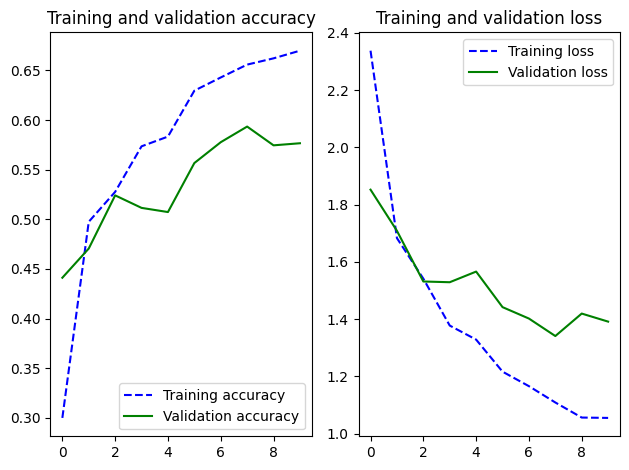

In [113]:
plot_training_analysis(vgg_combined_history)

#### Observations générales

1. **Graphique de précision (`accuracy`) :**
   - La précision d'entraînement augmente progressivement, atteignant environ **65 %** après 10 époques.
   - La précision de validation suit une trajectoire similaire en atteignant **58 %**. 

2. **Graphique des pertes (`loss`) :**
   - La perte d'entraînement diminue de manière constante et régulière, atteignant une valeur inférieure à **1,1**, ce qui montre une convergence efficace.
   - La perte de validation diminue jusqu'à atteindre **1,4**. Cela reflète une amélioration de la généralisation.

#### Interprétation

Les résultats montrent une nette amélioration par rapport au premier graphique (sans augmentation de données). 

1. **Amélioration de la généralisation :**
   - La précision de validation est significativement meilleure, montrant que le modèle a mieux appris à généraliser grâce à **l'augmentation de données** et à **l'apprentissage par transfert**.

2. **Écart modéré entre l'entraînement et la validation :**
   - Il existe un écart entre la précision d'entraînement et celle de validation (**environ 10 %**), mais celui-ci est bien inférieur à l'écart observé précédemment. Cela suggère un bon équilibre entre l'ajustement aux données d'entraînement et la généralisation.

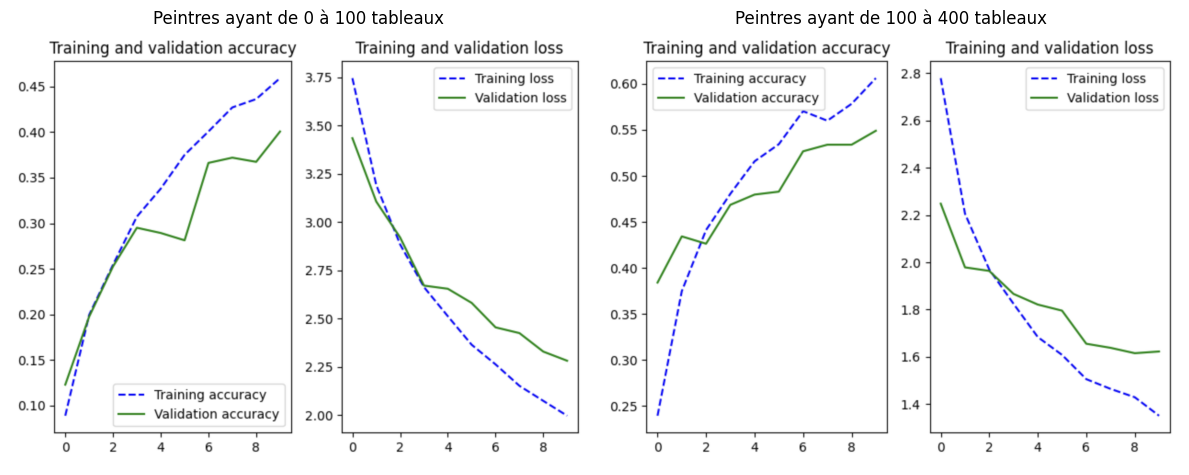

In [115]:
image1 = mpimg.imread('img/Peintre de 0 à 100.png')  
image2 = mpimg.imread('img/Peintre de 100 à 400.png')  

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

axs[0].imshow(image1)
axs[0].axis('off')  
axs[0].set_title("Peintres ayant de 0 à 100 tableaux")

axs[1].imshow(image2)
axs[1].axis('off') 
axs[1].set_title("Peintres ayant de 100 à 400 tableaux")  

# Afficher la figure
plt.tight_layout()
plt.show()

Les résultats que vous pouvez voir ci-dessus ont été obtenus pour des classes contenant réciproquement de 0 à 100 tableaux (tous les peintres) et de 100 à 400 tableaux (une partie des peintres)

## 5. Troisième approche : Fine Tuning

Le **fine-tuning** est une technique avancée qui consiste à ajuster un modèle pré-entraîné pour mieux l'adapter à une tâche spécifique.

#### Pourquoi faire du fine-tuning ?
- **Amélioration de la performance** : Le fine-tuning permet d’adapter les couches profondes du modèle aux particularités du dataset cible (dans ce cas, les peintures d'artistes). En réentraînant certaines couches, le modèle devient plus précis pour la classification des peintres.
- **Exploration des représentations spécifiques** : Tandis que les premières couches de VGG16 détectent des motifs généraux (comme les bords ou textures), les couches profondes capturent des informations plus spécifiques. Le fine-tuning permet à ces dernières d'apprendre des représentations pertinentes pour le domaine artistique.

Ainsi, le fine-tuning permet de tirer pleinement parti des modèles pré-entraînés tout en les ajustant à des tâches spécifiques comme la classification d'œuvres d'art.

In [119]:
conv_base.trainable = True

for layer in conv_base.layers[:15]:
    layer.trainable = False

vgg_combined.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,996,920 (129.69 MB)

 Trainable params: 13,506,834 (51.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 12,854,822 (49.04 MB)

In [120]:
epochs = 5

vgg_combined.compile(
    loss = 'CategoricalCrossentropy',
    optimizer = Adam(learning_rate=1e-4), 
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned = time.time()
vgg_combined_tuned_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned = time.time() - t_learning_vgg_combined_tuned

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 64s 703ms/step - accuracy: 0.6092 - loss: 1.2645 - val_accuracy: 0.6050 - val_loss: 1.3345
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 64s 714ms/step - accuracy: 0.6890 - loss: 0.9686 - val_accuracy: 0.6029 - val_loss: 1.3841
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 846ms/step - accuracy: 0.7279 - loss: 0.8396 - val_accuracy: 0.6397 - val_loss: 1.2206
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 843ms/step - accuracy: 0.7581 - loss: 0.7629 - val_accuracy: 0.6282 - val_loss: 1.3219
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 73s 812ms/step - accuracy: 0.8062 - loss: 0.5935 - val_accuracy: 0.6155 - val_loss: 1.4029
Learning time for 5 epochs : 354 seconds


In [121]:
t_prediction_vgg_combined = time.time()

score_vgg_combined_train = vgg_combined.evaluate(train_generator_augmented)
score_vgg_combined_validation = vgg_combined.evaluate(validation_generator)
score_vgg_combined_test= vgg_combined.evaluate(test_generator)
 
t_prediction_vgg_combined= time.time() - t_prediction_vgg_combined

print('Train accuracy:', score_vgg_combined_train[1])
print('Validation accuracy:', score_vgg_combined_validation[1])
print('Test accuracy:', score_vgg_combined_test[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined)

90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 555ms/step - accuracy: 0.8070 - loss: 0.6107
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 506ms/step - accuracy: 0.6089 - loss: 1.4607
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 508ms/step - accuracy: 0.6349 - loss: 1.3347
Train accuracy: 0.8090399503707886
Validation accuracy: 0.6155462265014648
Test accuracy: 0.6260504126548767
Time Prediction: 81.80 seconds


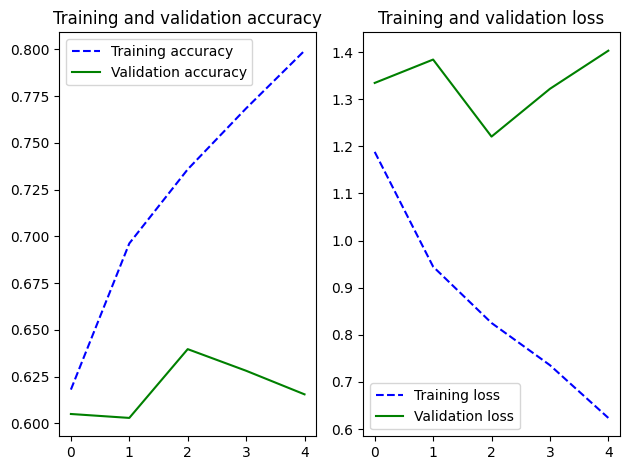

In [122]:
plot_training_analysis(vgg_combined_tuned_history)

#### Observations générales

1. **Graphique de précision (`accuracy`) :**
   - La précision d'entraînement augmente progressivement, atteignant environ **80 %** après 5 époques.
   - La précision de validation atteint un pic proche de **63 %** avant de diminuer légèrement. Cela indique un début de sur-apprentissage après les premières époques.

2. **Graphique des pertes (`loss`) :**
   - La perte d'entraînement diminue constamment, passant de **1,2** à environ **0,6**, ce qui montre une convergence efficace.
   - La perte de validation suit une trajectoire différente : elle diminue initialement mais commence à augmenter légèrement, atteignant environ **1,4**. Cela reflète une perte de généralisation due au sur-apprentissage.

#### Interprétation

1. **Amélioration grâce au fine-tuning :**
   - L'entraînement avec le fine-tuning a permis une amélioration des performances par rapport à l'utilisation simple de VGG16, notamment sur la précision d'entraînement et de validation.

2. **Détection de sur-apprentissage :**
   - L'écart croissant entre la précision/loss d'entraînement et de validation après quelques époques indique un sur-ajustement du modèle aux données d'entraînement. Cela peut limiter ses performances sur des données non vues.

3. **Écart modéré entre l'entraînement et la validation :**
   - Bien que le sur-apprentissage soit visible, l'écart entre la précision d'entraînement (80 %) et de validation (63 %) reste modéré, suggérant que le modèle a bien appris à généraliser dans les premières époques.

Ces résultats confirment que le fine-tuning améliore significativement les performances, mais un contrôle plus fin de l'entraînement pourrait encore optimiser la généralisation.

## 6. Quatrième approche : Couche supplémentaire dans la deuxième approche

L'ajout d'une couche supplémentaire entre la base convolutive (`conv_base`) et la couche d'aplatissement (`Flatten`) permet :  
1. **D'adapter les caractéristiques** pré-apprises par VGG16 aux spécificités des tableaux de peintres.  
2. **De réduire la dimensionnalité** via un pooling global, évitant un vecteur aplati trop volumineux.  
3. **De régulariser le modèle** avec une couche `Dropout`, limitant le surapprentissage.  

Cette approche vise à améliorer la performance et la généralisation du modèle sur ce domaine spécifique.

In [182]:
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Conv2D(128, (3, 3), padding='same'))  # Nouvelle couche de convolution
vgg_combined.add(BatchNormalization())  # Normalisation
vgg_combined.add(Activation('relu'))  # Activation
vgg_combined.add(GlobalAveragePooling2D())  # Pooling global pour réduire la dimensionnalité
vgg_combined.add(Dropout(0.5))  # Dropout pour régularisation
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(nclasses, activation='softmax'))

vgg_combined.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,342,802 (58.53 MB)

 Trainable params: 627,858 (2.40 MB)

 Non-trainable params: 14,714,944 (56.13 MB)

In [184]:
conv_base.trainable = False
vgg_combined.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,342,802 (58.53 MB)

 Trainable params: 627,858 (2.40 MB)

 Non-trainable params: 14,714,944 (56.13 MB)

In [186]:
epochs = 10

vgg_combined.compile(
    loss = 'CategoricalCrossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined = time.time()
vgg_combined_history = vgg_combined.fit(
    train_generator_augmented, 
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined = time.time() - t_learning_vgg_combined

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined))

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 579ms/step - accuracy: 0.2667 - loss: 2.4941 - val_accuracy: 0.4895 - val_loss: 1.7552
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 607ms/step - accuracy: 0.5743 - loss: 1.5777 - val_accuracy: 0.5956 - val_loss: 1.3516
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 826ms/step - accuracy: 0.6406 - loss: 1.2452 - val_accuracy: 0.6324 - val_loss: 1.1963
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 72s 804ms/step - accuracy: 0.6590 - loss: 1.1506 - val_accuracy: 0.6481 - val_loss: 1.1246
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 822ms/step - accuracy: 0.6939 - loss: 1.0033 - val_accuracy: 0.6292 - val_loss: 1.1965
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 73s 806ms/step - accuracy: 0.7166 - loss: 0.9238 - val_accuracy: 0.6513 - val_loss: 1.1505
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 824ms/step - accuracy: 0.7532 - loss: 0.8379 - val_accuracy: 0.6534 - val_loss: 1.1381
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 73s 812ms/step - accuracy: 0.7470 - loss: 0.8092 - val_accu

In [187]:
t_prediction_vgg_combined = time.time()

score_vgg_combined_train = vgg_combined.evaluate(train_generator_augmented)
score_vgg_combined_validation = vgg_combined.evaluate(validation_generator)
score_vgg_combined_test= vgg_combined.evaluate(test_generator)
 
t_prediction_vgg_combined= time.time() - t_prediction_vgg_combined

print('Train accuracy:', score_vgg_combined_train[1])
print('Validation accuracy:', score_vgg_combined_validation[1])
print('Test accuracy:', score_vgg_combined_test[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined )

90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 615ms/step - accuracy: 0.8510 - loss: 0.4851
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 554ms/step - accuracy: 0.6199 - loss: 1.3615
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 591ms/step - accuracy: 0.6248 - loss: 1.2367
Train accuracy: 0.8538892865180969
Validation accuracy: 0.6239495873451233
Test accuracy: 0.631302535533905
Time Prediction: 91.10 seconds


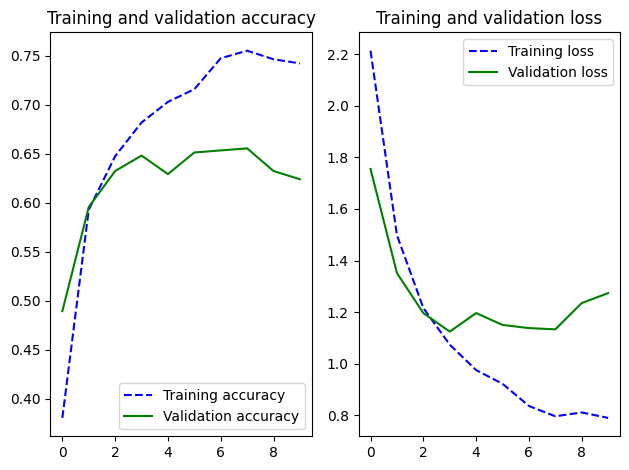

In [188]:
plot_training_analysis(vgg_combined_history)

#### Observations générales

1. **Graphique de précision (`accuracy`) :**
   - La précision d'entraînement augmente rapidement pour atteindre environ **75 %** après 10 époques.
   - La précision de validation atteint un pic d'environ **65 %** vers la 3ᵉ époque, puis stagne ou diminue légèrement, indiquant un début de sur-apprentissage.

2. **Graphique des pertes (`loss`) :**
   - La perte d'entraînement diminue de manière constante et régulière, passant de **2,2** à environ **0,8**, ce qui montre une bonne convergence.
   - La perte de validation diminue fortement au début, atteignant un minimum d'environ **1,2** après 3 époques, mais augmente ensuite légèrement, reflétant un sur-ajustement aux données d'entraînement.

#### Interprétation

1. **Effet de l'augmentation de données et de la couche supplémentaire :**
   - L'ajout d'une couche supplémentaire entre la base convolutive (VGG16) et la couche Flatten semble avoir amélioré la capacité du modèle à apprendre des représentations plus complexes.

2. **Signes de sur-apprentissage :**
   - La stagnation de la précision de validation après quelques époques, combinée à l'augmentation de la perte de validation, montre que le modèle commence à sur-apprendre les données d'entraînement.


Le modèle atteint une précision d'entraînement élevée (**75 %**) et une précision de validation correcte (**65 %**), ce qui montre une bonne capacité de généralisation malgré un sur-ajustement modéré.
L'utilisation de VGG16 avec augmentation de données et une couche supplémentaire semble être une la meilleure stratégie.

## 7. Cinquième approche : Augmentation de données uniquement dans les classes sous représentées

L'augmentation de données appliquée uniquement aux classes sous-représentées permet de rééquilibrer le dataset sans surcharger les classes majoritaires. Cette approche évite de créer un biais en faveur des classes déjà bien représentées et garantit un apprentissage plus équitable par le modèle.

De plus, contrairement aux approches précédentes où seules les classes d'artistes avec suffisamment d'oeuvres étaient utilisées, cette méthode permet d'exploiter l'entièreté du dataset. Ainsi, les résultats obtenus seront plus représentatifs de l'ensemble des données.

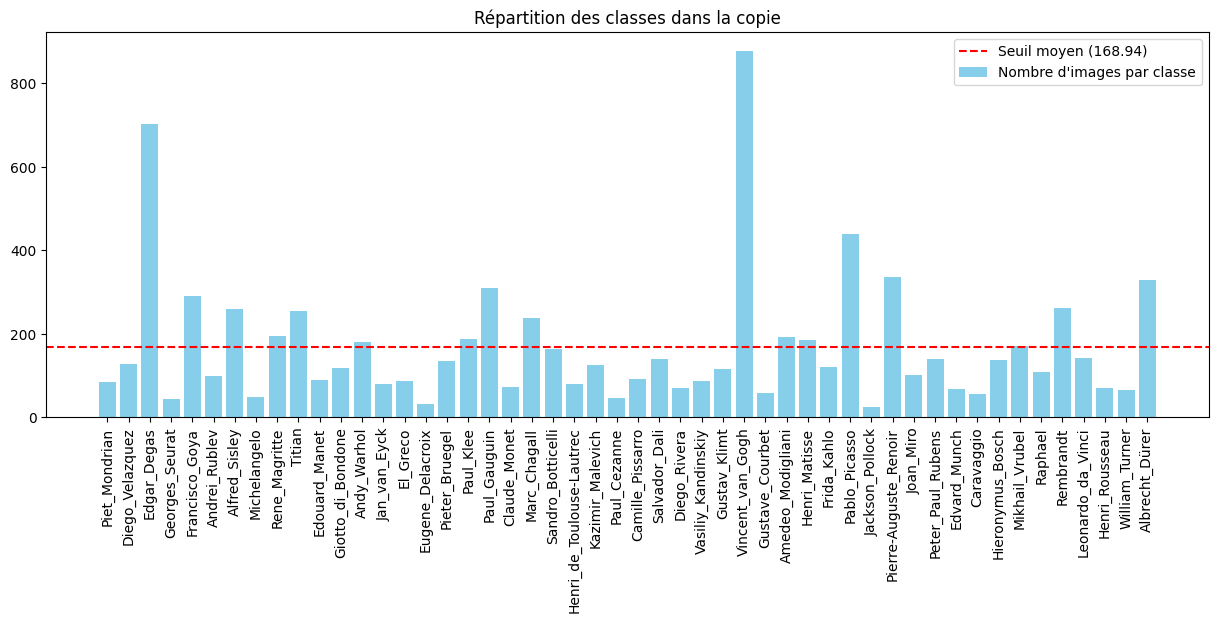

In [194]:
base_dir = "images_hq"
work_dir = "images_hq_copy"

if os.path.exists(work_dir):
    shutil.rmtree(work_dir)
shutil.copytree(base_dir, work_dir) 

class_dirs = os.listdir(work_dir)

class_counts = {cls: len(os.listdir(os.path.join(work_dir, cls))) for cls in class_dirs}

min_count = np.mean(list(class_counts.values()))
underrepresented_classes = {cls: count for cls, count in class_counts.items() if count < min_count}

plt.figure(figsize=(15,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', label="Nombre d'images par classe")
plt.axhline(y=min_count, color='red', linestyle='--', label=f"Seuil moyen ({min_count:.2f})") 
plt.xticks(rotation=90)
plt.title("Répartition des classes dans la copie")
plt.legend()
plt.show()

Ici, nous augmentons les classes sous représentées jusqu'à la valeur moyenne de toutes les classes (169 tableaux).

In [195]:
augmentation_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

for cls, count in underrepresented_classes.items():
    class_path = os.path.join(work_dir, cls)
    images = os.listdir(class_path)
    
    images_to_generate = int(min_count - count)
    existing_file_count = len(images)  

    for i in range(images_to_generate):
        img_path = os.path.join(class_path, np.random.choice(images))
        img = load_img(img_path)
        img_array = img_to_array(img)
        transformed = augmentation_gen.random_transform(img_array)
        transformed_img = array_to_img(transformed)
        
        new_file_name = f"{cls}_aug_{i}.jpg"
        save_path = os.path.join(class_path, new_file_name)
        
        transformed_img.save(save_path)

In [197]:
class_counts = {cls: len(os.listdir(os.path.join(work_dir, cls))) for cls in class_dirs}

plt.figure(figsize=(15,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', label="Nombre d'images par classe")
plt.axhline(y=min_count, color='red', linestyle='--', label=f"Seuil moyen ({min_count:.2f})") 
plt.xticks(rotation=90)
plt.title("Répartition des classes après augmentation")
plt.legend()
plt.show()

In [198]:
# Chemin des images augmentées
path = "images_hq_copy"

# Suppression et création du dossier "data2"
if os.path.exists("data2"):
    shutil.rmtree("data2")
os.mkdir("data2")

# Initialisation des listes pour stocker les données
images = []
peintres = []

# Parcours des sous-dossiers (un par peintre)
for dossier_auteur in sorted(os.listdir(path)):  # Trie les sous-dossiers
    path_auteur = os.path.join(path, dossier_auteur)
    if os.path.isdir(path_auteur):  # Vérifie que c'est un dossier
        for image in sorted(os.listdir(path_auteur)):  # Trie les fichiers
            src = os.path.join(path_auteur, image)  # Chemin source
            dst = os.path.join("data2", image)      # Chemin destination
            
            # Copie l'image dans le dossier "data"
            shutil.copyfile(src, dst)
            
            # Ajoute les informations dans les listes
            images.append(image)
            peintres.append(dossier_auteur)  # Le nom du dossier correspond au peintre

In [199]:
data2 = pd.DataFrame({
    'images': images,
    'peintre': peintres
})

In [200]:
data2.head()

images         peintre
0    Albrecht_Dürer_1.jpg  Albrecht_Dürer
1   Albrecht_Dürer_10.jpg  Albrecht_Dürer
2  Albrecht_Dürer_100.jpg  Albrecht_Dürer
3  Albrecht_Dürer_101.jpg  Albrecht_Dürer
4  Albrecht_Dürer_102.jpg  Albrecht_Dürer

In [201]:
data2.shape

(10957, 2)

In [202]:
nclasses = len(data2.peintre.unique())
print(nclasses)

50


In [203]:
label_encoder = LabelEncoder()

df2 = data2
df2['peintre'] = label_encoder.fit_transform(df2['peintre'])
df2['peintre'] = df2['peintre'].astype('str')

df2.head()

images peintre
0    Albrecht_Dürer_1.jpg       0
1   Albrecht_Dürer_10.jpg       0
2  Albrecht_Dürer_100.jpg       0
3  Albrecht_Dürer_101.jpg       0
4  Albrecht_Dürer_102.jpg       0

On divise notre jeu de données comme précédemment :

In [204]:
train_df2, test_df2 = train_test_split(df2, test_size=0.2, random_state=25)
train_df2, validation_df2 = train_test_split(train_df2, test_size=0.25, random_state=25)

In [205]:
batch_size = 32
img_width = 224
img_height = 224

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df2,
     "data2/",
    x_col = 'images',
    y_col = 'peintre',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df2,
     "data2/",
    x_col = 'images',
    y_col = 'peintre',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df2,
     "data2/",
    x_col = 'images',
    y_col = 'peintre',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 6572 validated image filenames belonging to 50 classes.
Found 2192 validated image filenames belonging to 50 classes.
Found 2192 validated image filenames belonging to 50 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="images". These filename(s) will be ignored.
  warnings.warn(


In [206]:
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Conv2D(128, (3, 3), padding='same'))  # Nouvelle couche de convolution
vgg_combined.add(BatchNormalization())  # Normalisation
vgg_combined.add(Activation('relu'))  # Activation
vgg_combined.add(GlobalAveragePooling2D())  # Pooling global pour réduire la dimensionnalité
vgg_combined.add(Dropout(0.5))  # Dropout pour régularisation
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(nclasses, activation='softmax'))

vgg_combined.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,351,026 (58.56 MB)

 Trainable params: 636,082 (2.43 MB)

 Non-trainable params: 14,714,944 (56.13 MB)

In [207]:
conv_base.trainable = False
vgg_combined.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,351,026 (58.56 MB)

 Trainable params: 636,082 (2.43 MB)

 Non-trainable params: 14,714,944 (56.13 MB)

In [208]:
epochs = 10

vgg_combined.compile(
    loss = 'CategoricalCrossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined = time.time()
vgg_combined_history = vgg_combined.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined = time.time() - t_learning_vgg_combined

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined))

/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 124s 595ms/step - accuracy: 0.1410 - loss: 3.5168 - val_accuracy: 0.3545 - val_loss: 2.5971
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 155s 751ms/step - accuracy: 0.3177 - loss: 2.6632 - val_accuracy: 0.4589 - val_loss: 2.0707
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 166s 807ms/step - accuracy: 0.4183 - loss: 2.2175 - val_accuracy: 0.5187 - val_loss: 1.8493
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 166s 808ms/step - accuracy: 0.4559 - loss: 2.0347 - val_accuracy: 0.5447 - val_loss: 1.7304
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 165s 801ms/step - accuracy: 0.5048 - loss: 1.8398 - val_accuracy: 0.5561 - val_loss: 1.6643
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 165s 799ms/step - accuracy: 0.5166 - loss: 1.7640 - val_accuracy: 0.5803 - val_loss: 1.5932
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 165s 802ms/step - accuracy: 0.5380 - loss: 1.6761 - val_accuracy: 0.5944 - val_loss: 1.5678
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 168s 818ms/step - accuracy: 0.5563 -

In [209]:
t_prediction_vgg_combined = time.time()

score_vgg_combined_train = vgg_combined.evaluate(train_generator)
score_vgg_combined_validation = vgg_combined.evaluate(validation_generator)
score_vgg_combined_test= vgg_combined.evaluate(test_generator)
 
t_prediction_vgg_combined= time.time() - t_prediction_vgg_combined

print('Train accuracy:', score_vgg_combined_train[1])
print('Validation accuracy:', score_vgg_combined_validation[1])
print('Test accuracy:', score_vgg_combined_test[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined)

206/206 ━━━━━━━━━━━━━━━━━━━━ 120s 583ms/step - accuracy: 0.7629 - loss: 0.9603
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 578ms/step - accuracy: 0.6001 - loss: 1.4514
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 586ms/step - accuracy: 0.6129 - loss: 1.4465
Train accuracy: 0.7583688497543335
Validation accuracy: 0.5971715450286865
Test accuracy: 0.606295645236969
Time Prediction: 201.36 seconds


In [210]:
plot_training_analysis(vgg_combined_history)

#### Observations générales

1. **Graphique de précision (`accuracy`) :**
   - La précision d'entraînement augmente rapidement, atteignant environ **57 %** après 10 époques.
   - La précision de validation suit une courbe similaire et reste très proche de celle de l'entraînement, atteignant environ **59 %**.

2. **Graphique des pertes (`loss`) :**
   - La perte d'entraînement diminue de manière constante, passant de **3,25** à environ **1,5**, montrant une convergence efficace.
   - La perte de validation diminue également de façon parallèle à celle de l'entraînement, atteignant une valeur proche de **1,5**, avec peu d'écart entre les deux courbes.

#### Interprétation

1. **Problème méthodologique :**
   - L'augmentation des données **avant** la séparation en ensembles d'entraînement, validation et test fausse les résultats. Les données augmentées étant trop similaires à celles d'origine, le modèle peut apprendre des patterns qu'il retrouve dans l'ensemble de validation. Cela explique l'écart très faible entre les courbes d'entraînement et de validation.

2. **Apparence trompeuse des performances :**
   - Bien que les courbes de précision et de perte suggèrent une bonne généralisation, les résultats ne sont pas fiables en raison de la fuite de données entre les ensembles d'entraînement et de validation. Les performances affichées ne reflètent pas la capacité réelle du modèle à généraliser sur des données inédites.

3. **Ce que nous aurions du faire :**
   - Effectuer la **séparation des ensembles avant toute augmentation de données**. Cela garantit l'indépendance des ensembles et une évaluation fiable des performances. 

En l'état, les résultats semblent prometteurs, avec des pertes et des précisions bien alignées entre l'entraînement et la validation. Cependant, ces performances ne sont pas représentatives de la généralisation du modèle donc on ne peut pas en tenir compte.

## 8. Comparaison

Pour cette partie, nous avons d'abord réduit les classes contenant plus de 400 tableaux à un maximum de 400. Cette réduction a permis de limiter l'impact des classes sur-représentées et de mieux équilibrer les données entre les peintres. 

Ensuite, nous avons fait varier le nombre de peintres inclus dans les données, en partant de 2 peintres jusqu'à 50. Cela nous a permis d'évaluer comment le modèle se comporte lorsque la tâche de classification devient progressivement plus complexe.

L'ensemble d'entraînement a été enrichi par une augmentation de données afin de rendre le modèle plus robuste aux variations. 
Ces augmentations ont uniquement été effectuées sur l'ensemble d'entraînement afin d'éviter toute contamination de l'ensemble de validation.

Pour chaque scénario (nombre de peintres sélectionnés), nous avons calculé l'accuracy de validation après 5 epochs afin de suivre l'évolution des performances du modèle. L'objectif était de comprendre à quel point la difficulté de la tâche influence la capacité du modèle à généraliser.

In [221]:
groups = [reduce_images(group, 0, 400) for _, group in data.groupby('peintre')]
data_balanced2 = pd.concat(groups, ignore_index=True)

peintres_classes = data_balanced2['peintre'].value_counts().index.tolist()

In [225]:
validation_accuracies = []
num_painters = range(2, 51)  # De 2 à 50 peintres

In [227]:
for n in num_painters:
    # Garder les `n` peintres les plus fréquents
    subset_painters = peintres_classes[:n]
    subset_data = data_balanced2[data_balanced2['peintre'].isin(subset_painters)]
    
    # Split les données
    train_df, test_df = train_test_split(subset_data, test_size=0.2, random_state=25)
    train_df, validation_df = train_test_split(train_df, test_size=0.25, random_state=25)

    # Générateurs d'images
    train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
        train_df,
        'data/',
        x_col='images',
        y_col='peintre',
        target_size=(img_width, img_height),
        class_mode='categorical',
        batch_size=batch_size
    )
    
    validation_generator = validation_datagen.flow_from_dataframe(
        validation_df,
        "data/",
        x_col='images',
        y_col='peintre',
        target_size=(img_width, img_height),
        class_mode='categorical',
        batch_size=batch_size
    )
    
    # Ajuster le modèle pour le nouveau nombre de classes
    nclasses = len(subset_painters)
    vgg_combined = Sequential()
    vgg_combined.add(Input(shape=(img_width, img_height, 3)))
    vgg_combined.add(conv_base)
    vgg_combined.add(Flatten())
    vgg_combined.add(Dense(256, activation='relu'))
    vgg_combined.add(Dense(nclasses, activation='softmax'))
    
    conv_base.trainable = False
    vgg_combined.compile(
        loss='CategoricalCrossentropy',
        optimizer=Adam(learning_rate=3e-4),
        metrics=['accuracy']
    )
    
    # Entraînement rapide pour mesurer la validation accuracy
    vgg_combined.fit(
        train_generator_augmented,
        validation_data=validation_generator,
        epochs=5,  
        verbose=0
    )
    
    # Évaluer sur l'ensemble de validation
    score = vgg_combined.evaluate(validation_generator, verbose=0)
    validation_accuracies.append(score[1])  # Stocker la validation accuracy

Found 480 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 720 validated image filenames belonging to 3 classes.
Found 240 validated image filenames belonging to 3 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 921 validated image filenames belonging to 4 classes.
Found 307 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 1118 validated image filenames belonging to 5 classes.
Found 373 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 1305 validated image filenames belonging to 6 classes.
Found 435 validated image filenames belonging to 6 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 1479 validated image filenames belonging to 7 classes.
Found 493 validated image filenames belonging to 7 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 1636 validated image filenames belonging to 8 classes.
Found 546 validated image filenames belonging to 8 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 1791 validated image filenames belonging to 9 classes.
Found 598 validated image filenames belonging to 9 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 1944 validated image filenames belonging to 10 classes.
Found 649 validated image filenames belonging to 10 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 2088 validated image filenames belonging to 11 classes.
Found 696 validated image filenames belonging to 11 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 2205 validated image filenames belonging to 12 classes.
Found 735 validated image filenames belonging to 12 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 2320 validated image filenames belonging to 13 classes.
Found 774 validated image filenames belonging to 13 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 2433 validated image filenames belonging to 14 classes.
Found 811 validated image filenames belonging to 14 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 2544 validated image filenames belonging to 15 classes.
Found 849 validated image filenames belonging to 15 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 2653 validated image filenames belonging to 16 classes.
Found 885 validated image filenames belonging to 16 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 2756 validated image filenames belonging to 17 classes.
Found 919 validated image filenames belonging to 17 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 2854 validated image filenames belonging to 18 classes.
Found 952 validated image filenames belonging to 18 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 2940 validated image filenames belonging to 19 classes.
Found 980 validated image filenames belonging to 19 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3024 validated image filenames belonging to 20 classes.
Found 1009 validated image filenames belonging to 20 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3108 validated image filenames belonging to 21 classes.
Found 1036 validated image filenames belonging to 21 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3190 validated image filenames belonging to 22 classes.
Found 1064 validated image filenames belonging to 22 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3270 validated image filenames belonging to 23 classes.
Found 1091 validated image filenames belonging to 23 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3348 validated image filenames belonging to 24 classes.
Found 1116 validated image filenames belonging to 24 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3423 validated image filenames belonging to 25 classes.
Found 1141 validated image filenames belonging to 25 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3495 validated image filenames belonging to 26 classes.
Found 1165 validated image filenames belonging to 26 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3567 validated image filenames belonging to 27 classes.
Found 1189 validated image filenames belonging to 27 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3636 validated image filenames belonging to 28 classes.
Found 1213 validated image filenames belonging to 28 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3702 validated image filenames belonging to 29 classes.
Found 1234 validated image filenames belonging to 29 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3763 validated image filenames belonging to 30 classes.
Found 1255 validated image filenames belonging to 30 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3822 validated image filenames belonging to 31 classes.
Found 1275 validated image filenames belonging to 31 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3877 validated image filenames belonging to 32 classes.
Found 1293 validated image filenames belonging to 32 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3931 validated image filenames belonging to 33 classes.
Found 1311 validated image filenames belonging to 33 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3984 validated image filenames belonging to 34 classes.
Found 1328 validated image filenames belonging to 34 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4036 validated image filenames belonging to 35 classes.
Found 1346 validated image filenames belonging to 35 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4086 validated image filenames belonging to 36 classes.
Found 1363 validated image filenames belonging to 36 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4135 validated image filenames belonging to 37 classes.
Found 1379 validated image filenames belonging to 37 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4184 validated image filenames belonging to 38 classes.
Found 1395 validated image filenames belonging to 38 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4227 validated image filenames belonging to 39 classes.
Found 1410 validated image filenames belonging to 39 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4269 validated image filenames belonging to 40 classes.
Found 1424 validated image filenames belonging to 40 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4311 validated image filenames belonging to 41 classes.
Found 1438 validated image filenames belonging to 41 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4352 validated image filenames belonging to 42 classes.
Found 1451 validated image filenames belonging to 42 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4392 validated image filenames belonging to 43 classes.
Found 1464 validated image filenames belonging to 43 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4427 validated image filenames belonging to 44 classes.
Found 1476 validated image filenames belonging to 44 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4460 validated image filenames belonging to 45 classes.
Found 1487 validated image filenames belonging to 45 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4489 validated image filenames belonging to 46 classes.
Found 1497 validated image filenames belonging to 46 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4518 validated image filenames belonging to 47 classes.
Found 1506 validated image filenames belonging to 47 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4543 validated image filenames belonging to 48 classes.
Found 1515 validated image filenames belonging to 48 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4562 validated image filenames belonging to 49 classes.
Found 1521 validated image filenames belonging to 49 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 4576 validated image filenames belonging to 50 classes.
Found 1526 validated image filenames belonging to 50 classes.


/opt/anaconda3/envs/hddltf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [232]:
plt.figure(figsize=(10, 6))
plt.plot(num_painters, validation_accuracies, marker='o', linestyle='-', color='b')
plt.title('Validation Accuracy en fonction du nombre de peintres')
plt.xlabel('Nombre de peintres')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

#### Analyse du graphique : Validation Accuracy en fonction du nombre de peintres

1. **Tendance générale :**
   - La courbe montre une décroissance progressive de l'accuracy de validation à mesure que le nombre de peintres augmente.
   - Avec un faible nombre de peintres (2 à 5), l'accuracy est très élevée, atteignant environ **85 - 95 %**.
   - À partir de 10 peintres, l'accuracy commence à fluctuer mais reste dans une plage acceptable (**70 % à 80 %**).
   - Lorsque le nombre de peintres dépasse 40, l'accuracy diminue nettement pour se stabiliser autour de **55 %**.

2. **Interprétation :**
   - La forte accuracy initiale pour un faible nombre de peintres montre que le modèle peut facilement distinguer les styles lorsque la classification est simple.
   - La diminution progressive indique que le modèle a plus de mal à généraliser avec un grand nombre de classes. Cela est attendu car l'augmentation du nombre de peintres rend la tâche plus complexe et introduit plus de chevauchements stylistiques entre les classes.
   - L'augmentation de données utilisée semble avoir aidé à maintenir une performance acceptable même avec un nombre élevé de peintres, bien que les limites du modèle soient atteintes à partir de 40 peintres.

3. **Conclusion :**
   - Pour maintenir une accuracy acceptable d'au moins **60 %**, il est essentiel de limiter le nombre de classes.
   - Au-delà de **40 peintres**, l'accuracy tombe en dessous de ce seuil, ce qui indique que le modèle ne parvient plus à généraliser correctement et à différencier efficacement les styles artistiques.